In [4]:
import sys
from pathlib import Path

# Project root
project_root = Path("D:/Personal/KAIM-10 Academy/Week 9/Project/portfolio-optimization-week9")

# Add src folder to sys.path
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

print("✅ src path added to Python path:", sys.path[-1])
# Import modules directly, NOT with `src.` prefix
import data_loader as dl
import data_cleaning as dc
import data_reshape as dr
import eda as eda

print("✅ src modules imported successfully")

✅ src path added to Python path: D:\Personal\KAIM-10 Academy\Week 9\Project\portfolio-optimization-week9\src
✅ src modules imported successfully


2. Data Cleaning & Understanding

In [5]:
# =========================
# Task 1: Preprocess & Reshape
# =========================

from pathlib import Path
import pandas as pd
import numpy as np

# -------------------------
# 1. Paths
# -------------------------
project_root = Path("D:/Personal/KAIM-10 Academy/Week 9/Project/portfolio-optimization-week9")
raw_file = project_root / "data" / "raw" / "all_assets_raw.csv"
processed_file = project_root / "data" / "processed" / "all_assets_clean.csv"

# -------------------------
# 2. Load raw data
# -------------------------
try:
    df_raw = pd.read_csv(raw_file, parse_dates=["Date"])
    print("Raw CSV loaded successfully")
except FileNotFoundError:
    print("⚠️ Raw CSV not found at", raw_file)
    df_raw = pd.DataFrame()  # empty DataFrame fallback

# -------------------------
# 3. Check if data exists
# -------------------------
if df_raw.empty:
    print("⚠️ Raw data is empty. Generating dummy sample data for testing...")
    dates = pd.date_range(start="2025-01-01", end="2025-01-10")
    df_raw = pd.DataFrame({
        "Date": np.tile(dates, 3),
        "Open": np.random.rand(len(dates)*3)*100,
        "Open.1": np.random.rand(len(dates)*3)*50,
        "Open.2": np.random.rand(len(dates)*3)*300,
        "High": np.random.rand(len(dates)*3)*100,
        "High.1": np.random.rand(len(dates)*3)*50,
        "High.2": np.random.rand(len(dates)*3)*300,
        "Low": np.random.rand(len(dates)*3)*100,
        "Low.1": np.random.rand(len(dates)*3)*50,
        "Low.2": np.random.rand(len(dates)*3)*300,
        "Close": np.random.rand(len(dates)*3)*100,
        "Close.1": np.random.rand(len(dates)*3)*50,
        "Close.2": np.random.rand(len(dates)*3)*300,
        "Volume": np.random.randint(1000, 10000, len(dates)*3),
        "Volume.1": np.random.randint(1000, 5000, len(dates)*3),
        "Volume.2": np.random.randint(5000, 20000, len(dates)*3),
        "Ticker": ["TSLA"]*len(dates) + ["BND"]*len(dates) + ["SPY"]*len(dates)
    })

print("Raw shape:", df_raw.shape)
df_raw.head()

# -------------------------
# 4. Identify numeric columns
# -------------------------
numeric_cols = [c for c in df_raw.columns if c not in ["Date", "Ticker"]]

# -------------------------
# 5. Clean Data
# -------------------------
# Fill missing values
df_clean = df_raw.copy()
df_clean[numeric_cols] = df_clean[numeric_cols].ffill().bfill()

# Ensure proper types
df_clean["Date"] = pd.to_datetime(df_clean["Date"])
df_clean["Ticker"] = df_clean["Ticker"].astype(str)
df_clean[numeric_cols] = df_clean[numeric_cols].apply(pd.to_numeric, errors="coerce")

print("✅ Data cleaned")
print("Clean shape:", df_clean.shape)
print(df_clean[numeric_cols].isna().sum())

# -------------------------
# 6. Basic Statistics & Types
# -------------------------
print("\nData types:\n", df_clean.dtypes)
print("\nBasic statistics:\n", df_clean[numeric_cols].describe())
print("\nMissing values after fill:\n", df_clean.isna().sum())

# -------------------------
# 7. Reshape Wide → Long
# -------------------------
# Rename columns for consistency
df_clean = df_clean.rename(columns={
    "Open": "Open_TSLA", "Open.1": "Open_BND", "Open.2": "Open_SPY",
    "High": "High_TSLA", "High.1": "High_BND", "High.2": "High_SPY",
    "Low": "Low_TSLA", "Low.1": "Low_BND", "Low.2": "Low_SPY",
    "Close": "Close_TSLA", "Close.1": "Close_BND", "Close.2": "Close_SPY",
    "Volume": "Volume_TSLA", "Volume.1": "Volume_BND", "Volume.2": "Volume_SPY"
})

# Apply reshaping
df_long = dr.reshape_wide_to_long(df_clean)
print("✅ Reshaped data to long format")
print("Long format shape:", df_long.shape)
df_long.head()
# -------------------------
# 8. Save cleaned & reshaped data
# -------------------------
processed_file.parent.mkdir(parents=True, exist_ok=True)
df_long.to_csv(processed_file, index=False)
print("✅ Saved cleaned long-format data to:", processed_file)

Raw CSV loaded successfully
Raw shape: (8326, 17)
✅ Data cleaned
Clean shape: (8326, 17)
Open           1
Open.1      2776
Open.2      5551
High           1
High.1      2776
High.2      5551
Low            1
Low.1       2776
Low.2       5551
Close          1
Close.1     2776
Close.2     5551
Volume         1
Volume.1    2776
Volume.2    5551
dtype: int64

Data types:
 Date        datetime64[us]
Open               float64
Open.1             float64
Open.2             float64
High               float64
High.1             float64
High.2             float64
Low                float64
Low.1              float64
Low.2              float64
Close              float64
Close.1            float64
Close.2            float64
Volume             float64
Volume.1           float64
Volume.2           float64
Ticker                 str
dtype: object

Basic statistics:
               Open       Open.1       Open.2         High       High.1  \
count  8325.000000  5550.000000  2775.000000  8325.000000  555

Long-format data shape: (24978, 7)


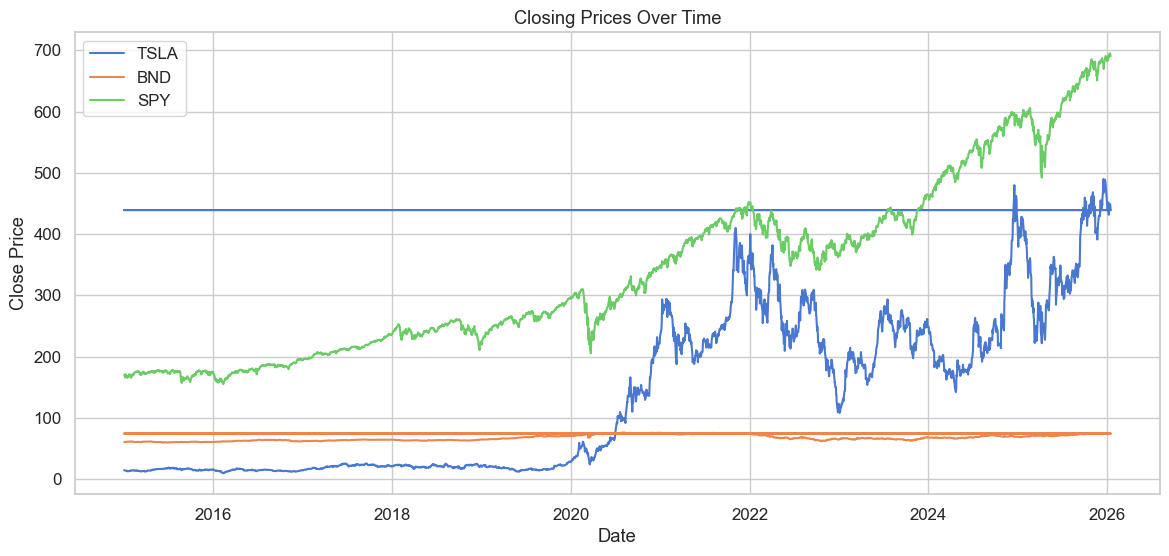

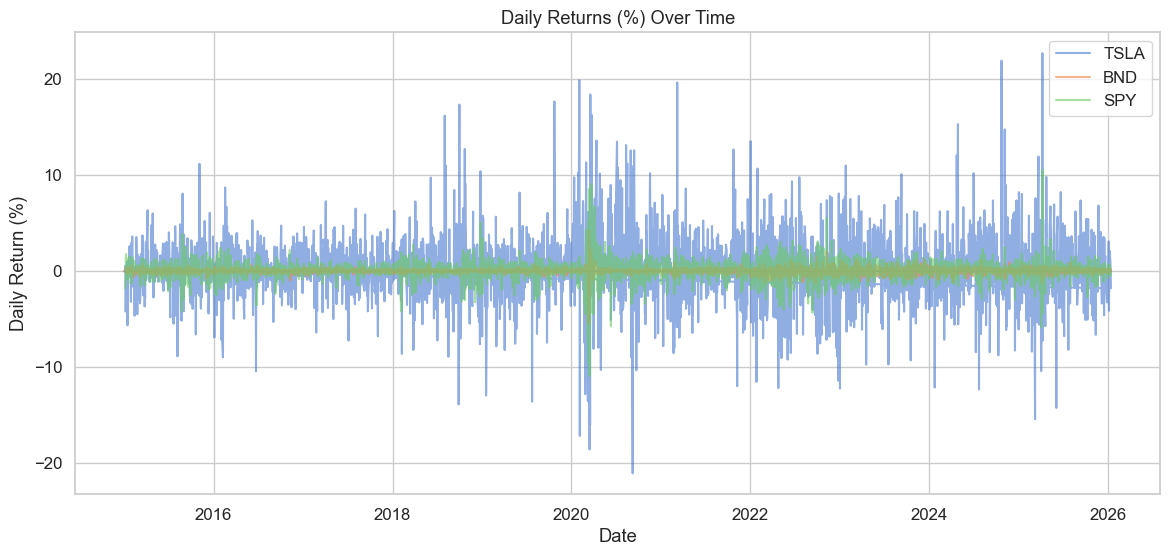

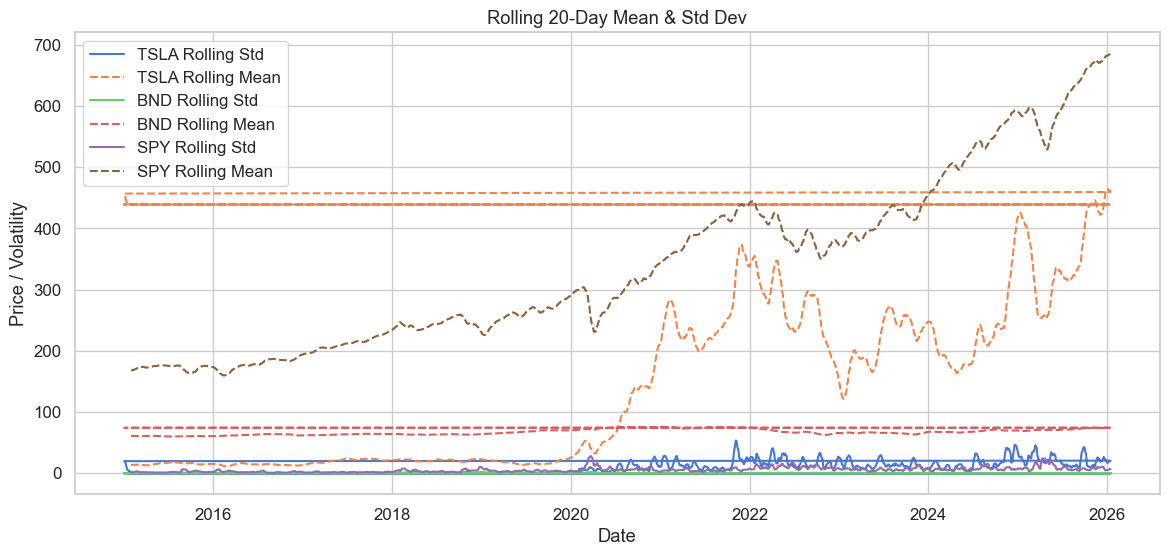

Number of outlier days detected: 344


,Date,Open,High,Low,Close,Volume,Ticker,Daily_Return
150,2015-08-06,16.636000,17.000000,15.741333,16.408667,219357000.0,TSLA,-8.884613
165,2015-08-27,15.400000,16.316668,15.387333,16.199333,114840000.0,TSLA,8.072407
202,2015-10-20,15.181333,15.240000,13.466667,14.202000,223500000.0,TSLA,-6.606755
213,2015-11-04,15.133333,15.516000,15.013333,15.442000,190896000.0,TSLA,11.173506
253,2016-01-04,15.381333,15.425333,14.600000,14.894000,102406500.0,TSLA,-6.916383


In [6]:
# =========================
# Task 3: Exploratory Data Analysis (EDA)
# =========================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# -------------------------
# 1️⃣ Ensure df_long is available
# -------------------------
# df_long comes from Task 1/2 cleaning and reshaping
print("Long-format data shape:", df_long.shape)
df_long.head()

# -------------------------
# 2️⃣ Import EDA functions from src/eda.py
# -------------------------
import sys
sys.path.append("D:/Personal/KAIM-10 Academy/Week 9/Project/portfolio-optimization-week9/src")
import eda

# -------------------------
# 3️⃣ Run EDA
# -------------------------

# Plot closing prices
eda.plot_closing_prices(df_long)

# Calculate daily returns
df_long = eda.calculate_daily_returns(df_long)

# Plot daily returns
eda.plot_daily_returns(df_long)

# Plot rolling statistics (mean & volatility)
eda.plot_rolling_stats(df_long, window=20)

# Detect outliers in daily returns
outliers_df = eda.detect_outliers(df_long)
print("Number of outlier days detected:", len(outliers_df))
outliers_df.head()

Long-format data shape: (24978, 7)
--- TSLA ---
ADF Test for TSLA Close:
  Test Statistic   : -1.9771
  p-value          : 0.2967
  # Lags used      : 35
  # Observations   : 8289
  Critical Value (1%) : -3.4311
  Critical Value (5%) : -2.8619
  Critical Value (10%) : -2.5670
  -> TSLA Close is likely non-stationary (fail to reject H0)

ADF Test for TSLA Daily Return:
  Test Statistic   : -17.6801
  p-value          : 0.0000
  # Lags used      : 26
  # Observations   : 8297
  Critical Value (1%) : -3.4311
  Critical Value (5%) : -2.8619
  Critical Value (10%) : -2.5670
  -> TSLA Daily Return is likely stationary (reject H0)

--- BND ---
ADF Test for BND Close:
  Test Statistic   : -2.0823
  p-value          : 0.2517
  # Lags used      : 32
  # Observations   : 5517
  Critical Value (1%) : -3.4315
  Critical Value (5%) : -2.8621
  Critical Value (10%) : -2.5670
  -> BND Close is likely non-stationary (fail to reject H0)

ADF Test for BND Daily Return:
  Test Statistic   : -12.4536
  p-v

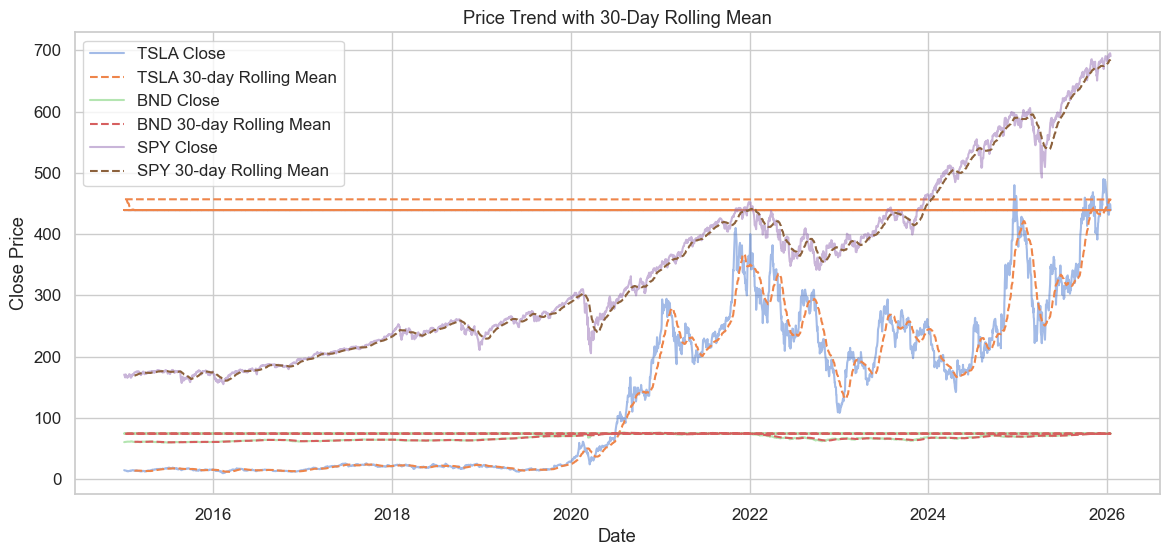

In [5]:
# =========================
# Task 4: Seasonality & Trend Analysis
# =========================
# -------------------------
# 1️⃣ Load cleaned long-format data (absolute path)
# -------------------------
from pathlib import Path
import pandas as pd

project_root = Path("D:/Personal/KAIM-10 Academy/Week 9/Project/portfolio-optimization-week9")
processed_file = project_root / "data" / "processed" / "all_assets_clean.csv"

# Check if the file exists
if not processed_file.exists():
    raise FileNotFoundError(f"Cleaned CSV not found at {processed_file}")

df_long = pd.read_csv(processed_file, parse_dates=["Date"])
print("Long-format data shape:", df_long.shape)
df_long.head()


# -------------------------
# 2️⃣ Ensure Daily_Return column exists
# -------------------------
if "Daily_Return" not in df_long.columns:
    df_long["Daily_Return"] = df_long.groupby("Ticker")["Close"].pct_change() * 100

# -------------------------
# 3️⃣ Augmented Dickey-Fuller Test Function
# -------------------------
def adf_test(series, series_name="Series"):
    """Perform Augmented Dickey-Fuller test and print results"""
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"ADF Test for {series_name}:")
    print(f"  Test Statistic   : {result[0]:.4f}")
    print(f"  p-value          : {result[1]:.4f}")
    print(f"  # Lags used      : {result[2]}")
    print(f"  # Observations   : {result[3]}")
    for key, value in result[4].items():
        print(f"  Critical Value ({key}) : {value:.4f}")
    if result[1] < 0.05:
        print(f"  -> {series_name} is likely stationary (reject H0)\n")
    else:
        print(f"  -> {series_name} is likely non-stationary (fail to reject H0)\n")

# -------------------------
# 4️⃣ Test Stationarity for Each Ticker
# -------------------------
tickers = df_long["Ticker"].unique()

for ticker in tickers:
    tmp = df_long[df_long["Ticker"] == ticker]
    print(f"--- {ticker} ---")
    adf_test(tmp["Close"], series_name=f"{ticker} Close")
    adf_test(tmp["Daily_Return"], series_name=f"{ticker} Daily Return")

# -------------------------
# 5️⃣ Plot Seasonal / Trend Patterns
# -------------------------
def plot_trend(df, window=30):
    plt.figure(figsize=(14,6))
    for ticker in df["Ticker"].unique():
        tmp = df[df["Ticker"] == ticker].copy()
        tmp["Rolling_Mean"] = tmp["Close"].rolling(window).mean()
        plt.plot(tmp["Date"], tmp["Close"], alpha=0.5, label=f"{ticker} Close")
        plt.plot(tmp["Date"], tmp["Rolling_Mean"], linestyle='--', label=f"{ticker} {window}-day Rolling Mean")
    plt.title(f"Price Trend with {window}-Day Rolling Mean")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()

plot_trend(df_long, window=30)

# -------------------------
# 6️⃣ Notes
# -------------------------
# - Use ADF results to decide if differencing is needed for ARIMA
# - Rolling mean helps visualize trend & seasonality

In [6]:
# =========================
# Task 5: Risk Metrics
# =========================

import sys
from pathlib import Path
import pandas as pd
import numpy as np

# -------------------------
# 1️⃣ Ensure EDA functions are imported
# -------------------------
project_root = Path("D:/Personal/KAIM-10 Academy/Week 9/Project/portfolio-optimization-week9")
sys.path.append(str(project_root / "src"))

import eda  # now includes calculate_var & calculate_sharpe

# -------------------------
# 2️⃣ Load cleaned long-format data if not already in memory
# -------------------------
processed_file = project_root / "data" / "processed" / "all_assets_clean.csv"
df_long = pd.read_csv(processed_file, parse_dates=["Date"])
print("Long-format data shape:", df_long.shape)

# Ensure daily returns exist
if "Daily_Return" not in df_long.columns:
    df_long = eda.calculate_daily_returns(df_long)

# -------------------------
# 3️⃣ Calculate Value at Risk (VaR)
# -------------------------
var_results = eda.calculate_var(df_long)
print("=== Value at Risk (95%) ===")
display(var_results)

# -------------------------
# 4️⃣ Calculate Sharpe Ratios
# -------------------------
sharpe_results = eda.calculate_sharpe(df_long)
print("=== Sharpe Ratios ===")
display(sharpe_results)

# -------------------------
# 5️⃣ Document Key Insights
# -------------------------
for ticker in df_long["Ticker"].unique():
    tmp = df_long[df_long["Ticker"] == ticker]
    mean_ret = tmp["Daily_Return"].mean()
    std_ret = tmp["Daily_Return"].std()
    print(f"{ticker}: Mean Daily Return = {mean_ret:.4f}%, Std Dev = {std_ret:.4f}%")
    print(f"{ticker}: VaR (95%) = {var_results[var_results['Ticker']==ticker]['VaR_95'].values[0]:.2f}%")
    print(f"{ticker}: Annualized Sharpe Ratio = {sharpe_results[sharpe_results['Ticker']==ticker]['Sharpe_Annual'].values[0]:.2f}")
    print("---")

Long-format data shape: (24978, 7)
=== Value at Risk (95%) ===


,Ticker,VaR_95
0,TSLA,2.878320
0,BND,0.329665
0,SPY,1.671900


=== Sharpe Ratios ===


,Ticker,Sharpe_Daily,Sharpe_Annual
0,TSLA,0.029912,0.474840
0,BND,0.016989,0.269692
0,SPY,0.050647,0.803992


TSLA: Mean Daily Return = 0.0628%, Std Dev = 2.0996%
TSLA: VaR (95%) = 2.88%
TSLA: Annualized Sharpe Ratio = 0.47
---
BND: Mean Daily Return = 0.0041%, Std Dev = 0.2386%
BND: VaR (95%) = 0.33%
BND: Annualized Sharpe Ratio = 0.27
---
SPY: Mean Daily Return = 0.0567%, Std Dev = 1.1193%
SPY: VaR (95%) = 1.67%
SPY: Annualized Sharpe Ratio = 0.80
---
